# Описание задания

В этом задании мы рассмотрим пример применения зловредного обучения. На первом этапе мы обучим модель на основе логистической регрессии классифицировать изображения в зависимости от того, что изображено. Далее мы будем моделировать различные атаки и анализировать то, насколько хуже модель стала справляться со своей задачей.

## Установка библиотеки Adversarial Robustness Toolbox (ART)

Библиотека предназначена для решения задач информационной безопасности и машинного обучения. ART предоставляет инструменты, которые позволяют разработчикам и исследователям защищать и оценивать модели и приложения машинного обучения от враждебных угроз: Evasion, Poisoning, Extraction и Inference.

In [2]:
!pip install -q adversarial-robustness-toolbox==1.18.2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


## Импорт библиотек и подготовка данных

Импортируем необходимые библиотеки

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import load_mnist

import warnings
warnings.simplefilter('ignore')

В качестве данных будем использовать датасет `MNIST`.

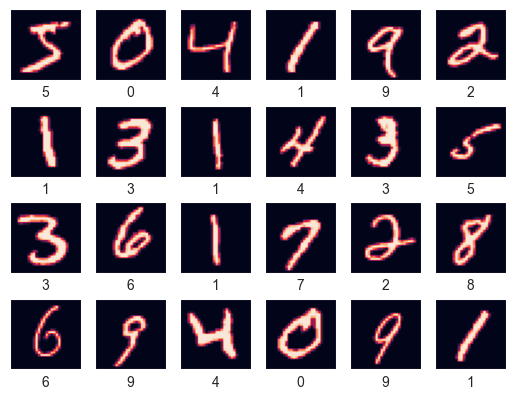

In [3]:
(x_train, y_train), (__, __), min_, max_ = load_mnist()

n_samples_train = x_train.shape[0]
n_features_train = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
x_train = x_train.reshape(n_samples_train, n_features_train)
y_train = np.argmax(y_train, axis=1)

n_samples_max = 1000

X = x_train[0:n_samples_max]
y = y_train[0:n_samples_max]

fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(x_train[i].reshape(28,28))
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(y_train[i])

## Построение и оценка модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию метке класса.

In [4]:
X_train, X_test, y_train_split, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Постройте гистограмму распределения объектов по классам в тренировочном наборе данных. Убедитесь, что классы сбалансированы. Вычислите долю элементов класса, указанного в вашем индивидуальном задании.

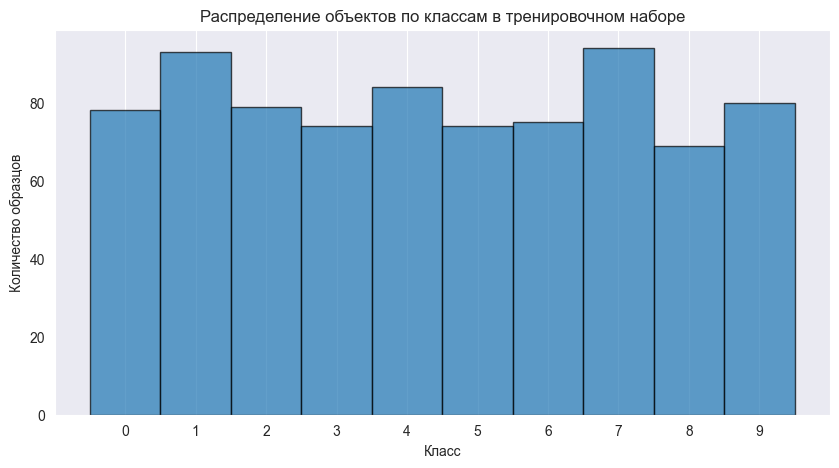

Доля объектов класса 0: 0.0975


In [5]:
plt.figure(figsize=(10, 5))
plt.hist(y_train_split, bins=np.arange(11) - 0.5, edgecolor='black', alpha=0.7)
plt.xticks(range(10))
plt.xlabel('Класс')
plt.ylabel('Количество образцов')
plt.title('Распределение объектов по классам в тренировочном наборе')
plt.grid(axis='y')
plt.show()

unique_classes, counts = np.unique(y_train_split, return_counts=True)
class_distribution = counts / counts.sum()

proportion_class_0 = class_distribution[np.where(unique_classes == 0)[0][0]]
print(f'Доля объектов класса 0: {proportion_class_0:.4f}')

Обучите модель <code>LogisticRegression()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [7]:
model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(X_train, y_train_split)

LogisticRegression(max_iter=1000, random_state=0)

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [8]:
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score (weighted): {f1:.4f}')

F1 Score (weighted): 0.8690


# Атака при помощи PGD (Projected Gradient Descent)

Реализуем атаку при помощи Projected Gradient Descent. Создайте переменную `art_classifier` и поместите в нее экземпляр класса [`SklearnClassifier`](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/estimators/classification_scikitlearn.html) из библиотеки ART, где в качестве параметра `model` укажите ранее обученную модель логистической регрессии из задания выше.

In [9]:
art_classifier = SklearnClassifier(model)

PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


При помощи `ProjectedGradientDescent()` из библиотеки ART создайте генератор искаженных данных с параметрами, указанными в вашем индивидуальном задании. В качестве параметра `estimator` используйте объект, который находится в переменной `art_classifier` из предыдущей ячейки.

In [10]:
pgd = ProjectedGradientDescent(estimator=art_classifier,
                                norm=np.inf,
                                eps=.3,
                                eps_step=0.1,
                                max_iter=20,
                                targeted=False,
                                num_random_init=0,
                                batch_size=128)

При помощи метода `.generate()` сгенерируйте искаженные тестовые данные.

In [11]:
x_test_adv = pgd.generate(x=X_test)

PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Постройте пару изображений (оригинальное и искаженное) из тестовых данных с индексом, указанным в вашем индивидуальном задании, сравните результаты. Заметно ли искажение человеческому глазу?

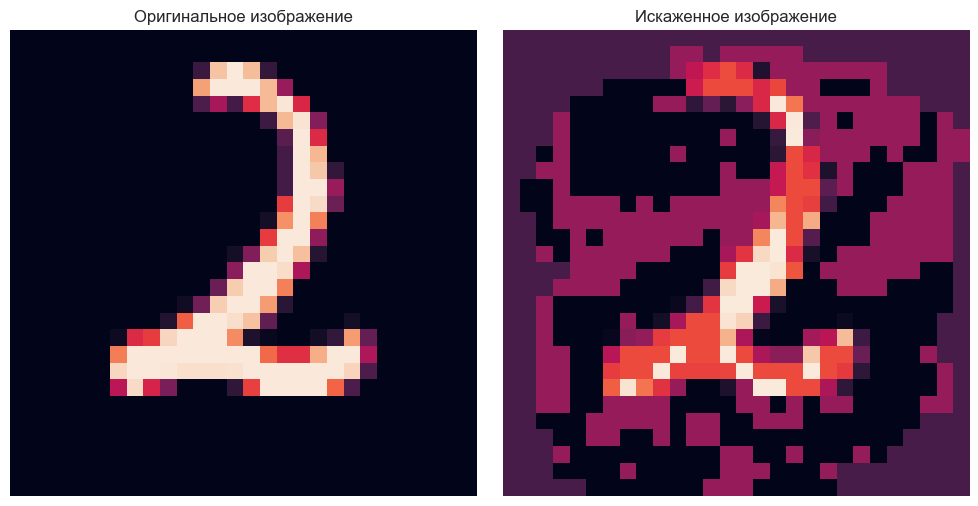

In [12]:
img_num = 0

# Создание фигуры и осей
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 ряд, 2 колонки

# Отображение первого изображения
ax[0].imshow(X_test[img_num, :].reshape((28, 28)))
ax[0].axis('off')  # Отключение осей для первого изображения
ax[0].set_title('Оригинальное изображение')  # Заголовок для первого изображения

# Отображение второго изображения
ax[1].imshow(x_test_adv[img_num, :].reshape((28, 28)))
ax[1].axis('off')  # Отключение осей для второго изображения
ax[1].set_title('Искаженное изображение')  # Заголовок для второго изображения

# Показать график
plt.tight_layout()  # Для улучшения компоновки
plt.show()

Определите, какую метку класса для объекта тестовых данных с индексом, указанным в вашем индивидуальном задании, предсказала модель в случае оригинальных и искаженных данных.

In [14]:
original_prediction = art_classifier.predict(np.expand_dims(X_test[img_num], axis=0))
print(f"Predicted label for original data: {np.argmax(original_prediction)}")

adversarial_prediction = art_classifier.predict(np.expand_dims(x_test_adv[img_num], axis=0))
print(f"Predicted label for adversarial data: {np.argmax(adversarial_prediction)}")

Predicted label for original data: 2
Predicted label for adversarial data: 1


Оцените модель на искаженных тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [15]:
y_pred_adv = art_classifier.predict(x_test_adv)
f1 = f1_score(y_test, np.argmax(y_pred_adv, axis=1), average='weighted')
print(f'F1 Score on adversarial data (weighted): {f1:.3f}')

F1 Score on adversarial data (weighted): 0.040
